# Strong Lens Candidate Spectra

Plot a handful of spectra from SLACS associated to DESI targets (list from Arjun, May 2021).

In [1]:
import os
from glob import glob

from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, unique, Table
from desispec.spectra import stack as specstack
from desispec.io import read_spectra, write_spectra
from desispec.coaddition import coadd_cameras

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## SLACS-DESI Target List

SLACS catalog is available in [Table 4 of this paper](https://iopscience.iop.org/article/10.1086/589327/fulltext/). Fields are SLACSID, RA, Dec, TARGETID, and TILEID.

In [2]:
slacs_data = [
['114052.69+564044.5',       175.21954,       56.679028,     39633345654556340,       81058],
['143627.54-000029.2',       219.11475,   -0.0081111113,     39627788403084375,         256],
['161843.10+435327.4',       244.67958,       43.890944,     39633149696675337,         367],
['161843.10+435327.4',       244.67958,       43.890944,     39633149696675337,         364],
['161843.10+435327.4',       244.67958,       43.890944,     39633149696675337,         369],
['141622.34+513630.4',       214.09308,       51.608444,     39633271436346288,         178],
['141622.34+513630.4',       214.09308,       51.608444,     39633271436346288,         183],
['141622.34+513630.4',       214.09308,       51.608444,     39633271436346288,         182]]

### Extract Spectra and Redshifts

Loop through daily cumulative reductions and grab spectra and redrock redshifts.

These can also be accessed directly through the Legacy Survey viewer using the URL pattern https://www.legacysurvey.org/viewer-desi/?zoom=15&targetid=39633345654556340 (for example).

In [3]:
# Change reduction: daily, denali, etc.
redux = 'daily'

# Loop through object list and extract spectra.
lenspec = None

for slacs_obj in slacs_data:
    slacs_id, ra, dec, targetid, tileid = slacs_obj
    
    # Search for tile data.
    tile_folders = sorted(glob('{}/daily/tiles/cumulative/{}/*'.format(os.environ['DESI_SPECTRO_REDUX'], tileid)))
    if tile_folders:
        # Grab coadds from the last cumulative folder.
        tile_folder = tile_folders[-1]
        coadds = sorted(glob('{}/coadd*'.format(tile_folder)))
        
        # Search for the matching targetid.
        for coadd in coadds:
            try:
                spectra = read_spectra(coadd)

                # Select matching target IDs from the SLACS list and read out associated spectra.
                sselect = np.in1d(spectra.fibermap['TARGETID'], targetid)
                if np.any(sselect):
                    spectra = spectra[sselect]
                    if not hasattr(spectra, 'scores_comments'):
                        spectra.scores_comments = None

                    # Extract corresponding best-fit redshift.
                    zbfile = coadd.replace('coadd', 'zbest')
                    zbest = fits.open(zbfile)['ZBEST'].data
                    zselect = np.in1d(zbest['TARGETID'], targetid)
                    zbest = zbest[zselect]

                    # Append spectra to a larger list of spectra, stored in memory.
                    # Note that an EXPID is required in the update step below, but the coadded spectra
                    # have a FIRST_EXPID and a LAST_EXPID. So copy one of these as a hack.
                    spectra.fibermap['EXPID'] = spectra.fibermap['LAST_EXPID']
                    spectra.extra_catalog = zbest

                    if lenspec is None:
                        lenspec = spectra
                    else:
                        lenspec = specstack([lenspec, spectra])
                    break
            except OSError as e:
                print(e)

if not hasattr(lenspec, 'scores_comments'):
    lenspec.scores_comments = None

INFO:spectra.py:253:read_spectra: iotime 0.971 sec to read coadd-0-81058-thru20210324.fits at 2021-06-03T08:41:21.150525
INFO:spectra.py:253:read_spectra: iotime 0.950 sec to read coadd-1-81058-thru20210324.fits at 2021-06-03T08:41:22.626179
INFO:spectra.py:253:read_spectra: iotime 0.899 sec to read coadd-2-81058-thru20210324.fits at 2021-06-03T08:41:24.075705
INFO:spectra.py:253:read_spectra: iotime 0.933 sec to read coadd-3-81058-thru20210324.fits at 2021-06-03T08:41:25.591088
INFO:spectra.py:253:read_spectra: iotime 0.804 sec to read coadd-4-81058-thru20210324.fits at 2021-06-03T08:41:26.938850
INFO:spectra.py:253:read_spectra: iotime 0.799 sec to read coadd-0-256-thru20210410.fits at 2021-06-03T08:41:28.517065
Header missing END card.
INFO:spectra.py:253:read_spectra: iotime 0.835 sec to read coadd-1-256-thru20210410.fits at 2021-06-03T08:41:29.914692
Header missing END card.
INFO:spectra.py:253:read_spectra: iotime 0.803 sec to read coadd-2-256-thru20210410.fits at 2021-06-03T08:4

### Plot Results

Code to grab image cutouts and plot spectra together.

In [4]:
import requests

def get_cutout(targetid, ra, dec, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    """
    img_name = '{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        if verbose:
            print('Accessing {}'.format(img_name))
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&%22/pix=0.25&layer=dr8&size=180'.format(ra, dec)
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
    
    return img_name

In [5]:
from scipy.ndimage import gaussian_filter1d

mpl.rc('figure', max_open_warning = 0)

In [6]:
# Emission and absorption lines from Prospect tables.
emi_lines = ascii.read('emission_lines.txt', comment='#', names=['name','longname','lambda','vacuum','major'])
abs_lines = ascii.read('absorption_lines.txt', comment='#', names=['name','longname','lambda','vacuum','major'])

emi_lines_major = emi_lines[emi_lines['major']=='True']
abs_lines_major = abs_lines[abs_lines['major']=='True']

39633345654556340 81849 81058 2305
39627788403084375 84246 256 2453
39633149696675337 85351 367 1709
39633149696675337 84242 364 1705
39633149696675337 86514 369 1933
39633271436346288 85628 178 751
39633271436346288 87821 183 818
39633271436346288 87482 182 992


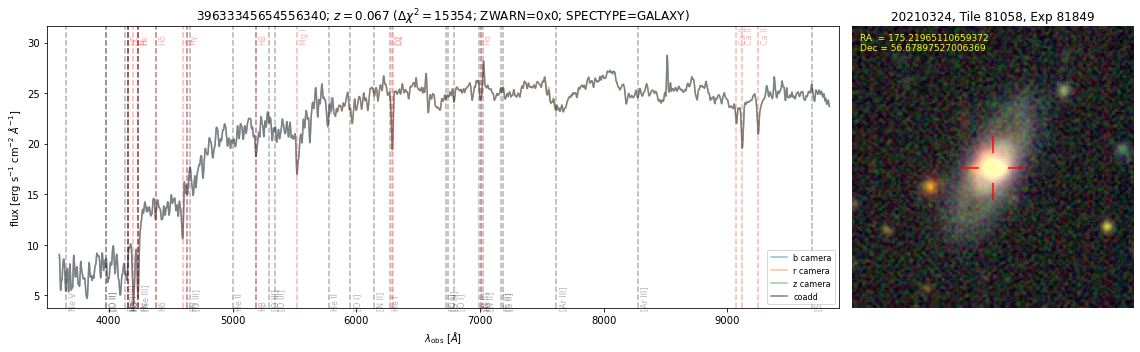

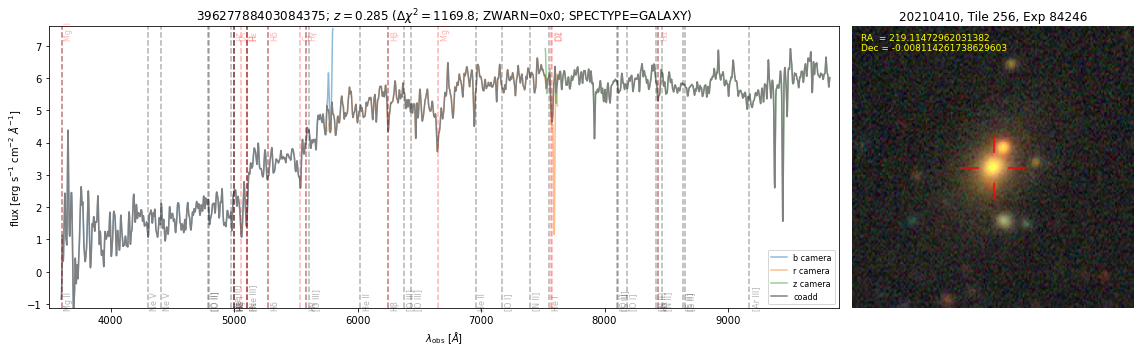

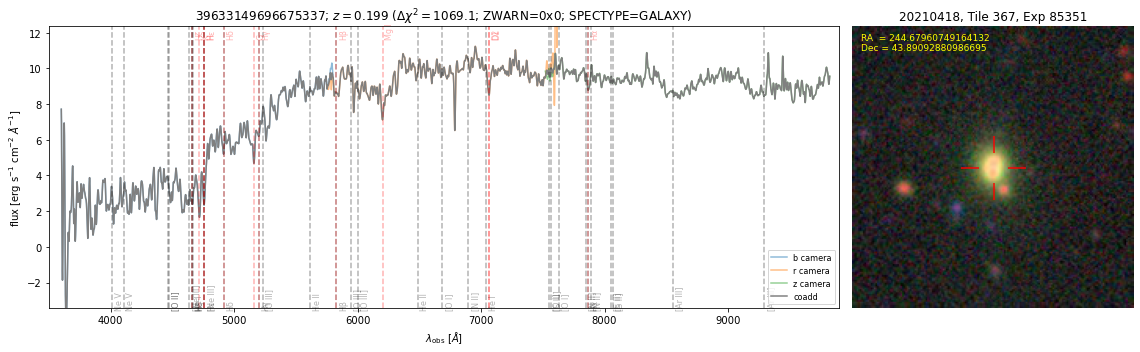

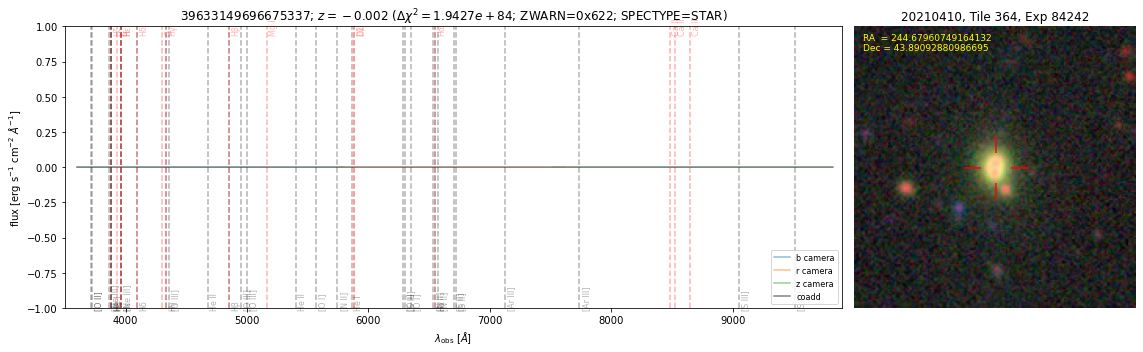

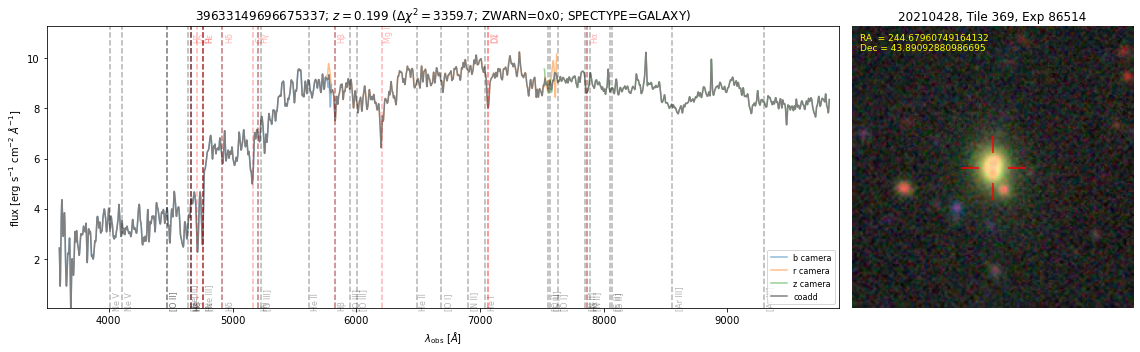

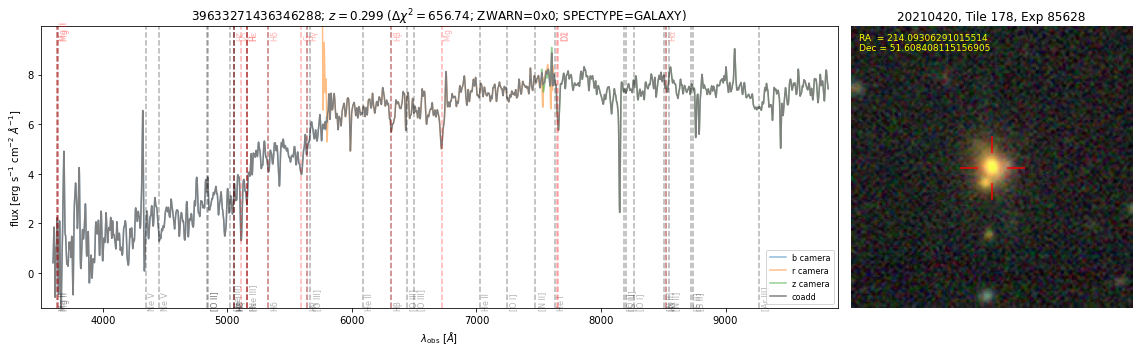

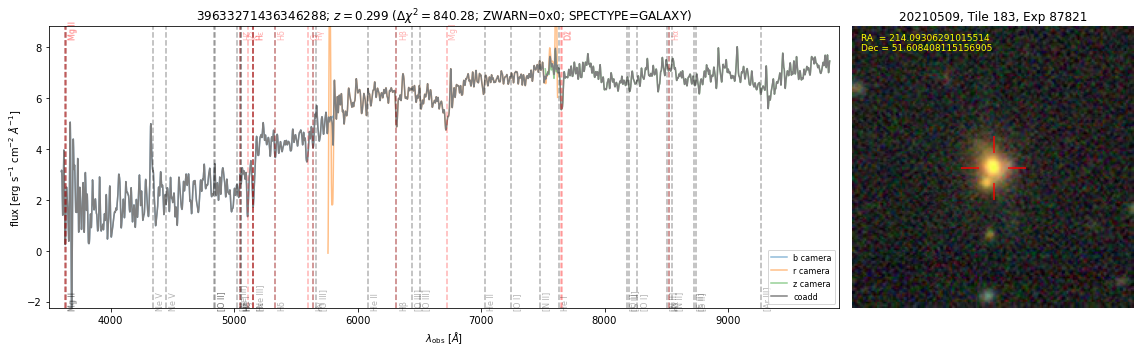

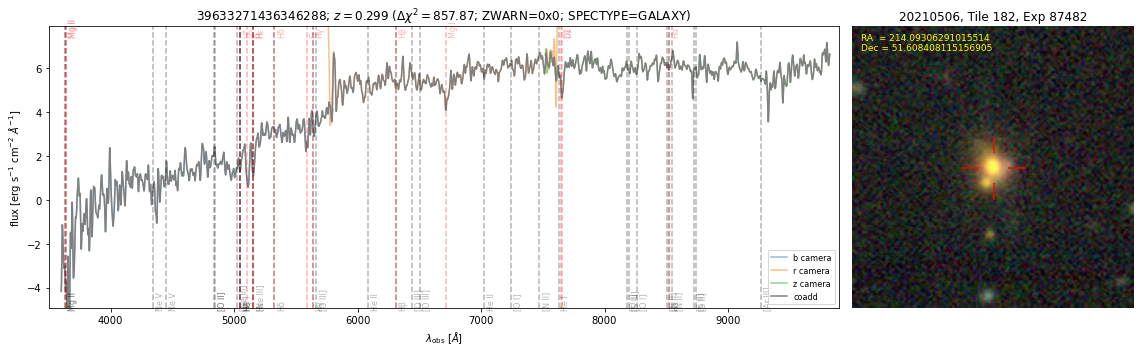

In [7]:
for i in range(lenspec.num_spectra()):
    
    fig, axes = plt.subplots(1,2, figsize=(16,5), gridspec_kw={'width_ratios':[3,1.1]},
                             tight_layout=True)
    
    # Plot the spectra
    ax = axes[0]
    
    # Plot the spectra from each spectrograph.
    for band in 'brz':
        smoothed = gaussian_filter1d(lenspec.flux[band][i], 5)
        ax.plot(lenspec.wave[band], smoothed, alpha=0.5, label='{} camera'.format(band))
        
    # Coadd the cameras and plot the resulting flux.
    coadd_spec = coadd_cameras(lenspec[i])
    smoothed = gaussian_filter1d(coadd_spec.flux['brz'][0], 5)
    fmin = 0.9*np.min(smoothed)
    fmax = 1.1*np.max(smoothed)
    if fmin == fmax:
        fmin, fmax = -1, 1
    ax.plot(coadd_spec.wave['brz'], smoothed, color='gray', label='coadd')
        
    zbest = lenspec.extra_catalog[i]
    z = zbest['Z']
    dchi2 = zbest['DELTACHI2']
    zwarn = zbest['ZWARN']
    sptype = zbest['SPECTYPE']
    
    for eline in emi_lines:
        wl = eline['lambda']*(1 + z)
        if wl > 3600 and wl < 9800:
            ax.axvline(wl, ls='--', color='k', alpha=0.3)
            ax.text(wl+20, fmin, eline['name'], fontsize=8, rotation=90, alpha=0.3)

    for aline in abs_lines:
        wl = aline['lambda']*(1 + z)
        if wl > 3600 and wl < 9800:
            ax.axvline(wl, ls='--', color='r', alpha=0.3)
            ax.text(wl+20, 0.95*fmax, aline['name'], color='r', fontsize=8, rotation=90, alpha=0.3)

    ax.set(xlabel=r'$\lambda_{\mathrm{obs}}$ [$\AA$]',
           xlim=(3500,9900),
           ylabel=r'flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
           ylim=(fmin, fmax),
           title=r'{}; $z={:.3f}$ ($\Delta\chi^2={:.5g}$; ZWARN=0x{:x}; SPECTYPE={:s})'.format(lenspec.fibermap[i]['TARGETID'], z, dchi2, zwarn, sptype.decode('utf-8')),
          )
    
    ax.legend(loc='lower right', fontsize=8)
    
    # Plot the image cutout.
    ax = axes[1]
    
    obj = lenspec.fibermap[i]
    img_file = get_cutout(obj['TARGETID'], obj['TARGET_RA'], obj['TARGET_DEC'])
    img = mpl.image.imread(img_file)

    ax.imshow(img)

    x1, x2, x3, x4 = [90, 90], [70, 80], [90, 90], [100,110]
    y1, y2, y3, y4 = [70, 80], [90, 90], [100,110], [90,90]
    ax.plot(x1, y1, x2, y2, x3, y3, x4, y4, color='r', linewidth=2, alpha=0.7)
    ax.text(5,15, '{:3s} = {}\n{:3s} = {}'.format('RA', obj['TARGET_RA'], 'Dec', obj['TARGET_DEC']), color='yellow', fontsize=9)
    ax.set(aspect='equal',
           title='{}, Tile {}, Exp {}'.format(obj['LAST_NIGHT'], obj['TILEID'], obj['EXPID']))
    ax.axis('off')
    
    print(obj['TARGETID'], obj['EXPID'], obj['TILEID'], obj['FIBER'])
    
    fig.savefig('lens_{}_{}_{:06d}_{:06d}.png'.format(obj['TARGETID'], obj['LAST_NIGHT'], obj['TILEID'], obj['EXPID']), dpi=100)
    
#     # Clean up to avoid memory problems.
#     fig.clear()
#     plt.close(fig)

### Dump Spectra to FITS

Dump the selected candidate spectra to a FITS file. In principle this should be readable for running tests with redrock.

In [8]:
write_spectra('slacs_desi_dailyspectra.fits', lenspec)

INFO:spectra.py:154:write_spectra: iotime 0.207 sec to write slacs_desi_dailyspectra.fits at 2021-06-03T08:42:58.992695


'/global/u2/s/sybenzvi/desi/stronglens/doc/nb/slacs_desi_dailyspectra.fits'

In [9]:
np.savez('slacs_desi_dailyspectra.npz', bands=lenspec.bands, wave=lenspec.wave, flux=lenspec.flux, ivar=lenspec.ivar, fibermap=lenspec.fibermap)